## Machine Learning versus Statistical Models for Time Series Forecasting

Floyd Mayweather versus Muhammed Ali. The greatest of all time versus the immortal legend. Wouldn’t that be the best match-up imaginable? No. Believe it or not, but I have a better one for you: The all-rounder with unlimited potential versus the consistently performing classic. Machine learning versus statistical models! Which one is better in time series forecasting? 

Forecasting researcher Spyros Makridakis has been organizing several time series forecasting competitions (know as the M Competitions) to gain insights on the performance of different models. In the first three versions of the competition (1982, 1993 and 2000), only statistical models were used. In the last version of the competition however (2018), there was a significant number of machine learning models submitted as well. This blog provides a case that shows how both types of models perform in different scenarios. Let’s see if we can get some valuable insights on the pros and cons of both types of models. The used models were built in Python, and the code is available here (add link) as a Jupyter notebook.

## The match
Before we dive into the comparison, let’s give our definition of statistical and machine learning models. We define a statistical model as a model that is interpretable based on its architecture and mathematical representation. Examples of these are exponential smoothing and autoregressive-moving-average (ARIMA) models. We define a machine learning model as a model that has a relatively complex architecture with a significant number of not easy interpretable parameters. Examples of these in time series forecasting are recurrent neural networks (RNN) including long short-term memory (LSTM) cells or feedforward neural networks based on dilated causal convolutional layers. 

Based on these definitions the statistical model should be able to give us insights the machine learning model does not. Furthermore, due to the difference in number of parameters we expect the statistical model to require significant less training time compared to the machine learning model. At the same time this does make the machine learning model more flexible and hopefully this makes it able to learn certain patterns by itself.

To see how both methods perform relative to each other, we picked one model of each type and use it to predict in three different scenarios. We look at a set of performance indicators that we will assess in the different sections of this blog. The following indicators were taken into account: Accuracy, learnability, explainability, modeling time, training time and data utility. They will be discussed throughout the blog. The match will take place in the city of Chicago. The time series data used is a data set of hourly energy consumption recorded by ComEd, the largest electricity distributor in (northern) Illinois, USA. The data has a horizon of January 1st, 2011 till August 2nd, 2018. Below is a plot of the data. 

In [1]:
# Import libraries and functions
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 


# Function that interpolates missing values by taking the mean of the surrounding values or alternatively taking one of
# the surrounding values
# data:   pd.DataFrame,   The data on which interpolation is done
def interpolate(data):
    full_date_range = pd.date_range(min(data.index), max(data.index), freq='H')
    hour = dt.timedelta(hours=1)
    for i in full_date_range:  # interpolate mean of values around missing value
        if i not in data.index:  # if there is a missing value take mean of 2 surrounding values
            if i - hour in data.index and i + hour in data.index:  # only if those 2 values exist
                data[i] = (data[i - hour] + data[i + hour]) / 2
            else:  # otherwise take the previous recorded value (we assume that data[0] exists)
                data[i] = data[i - hour]

    return data

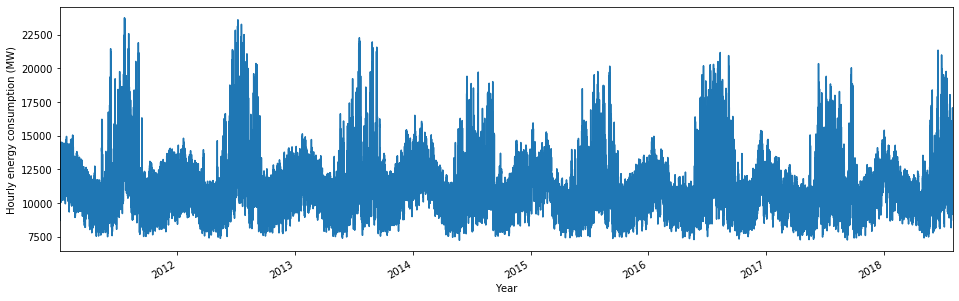

In [2]:
# Read in the data and plot graph
pjm_data = pd.read_csv("Data/PJM_energy_usage_1999-2017.csv")
pjm_data.index = pd.to_datetime(pjm_data["Datetime"])
start, end = '2011-01-01 01:00:00', '2018-08-02 23:00:00'  # this is the date range of COMED
comed_data = pjm_data.loc[(pjm_data.index >= start) & (pjm_data.index <= end), 'COMED']
comed_data = comed_data.groupby(comed_data.index.to_period('H')).mean()  # take mean for multiple recordings (4 cases)
comed_data.index = comed_data.index.to_timestamp()  # set index back to datetime object
comed_data = comed_data.sort_index()  # sort the index
comed_data = interpolate(comed_data)  # interpolate missing values (11 cases)


comed_data.plot(figsize=(16.0, 5.0))
plt.rc('figure', figsize=(16.0, 5.0))  # make sure all future pots have the same figure size
plt.xlabel('Year')
plt.ylabel('Hourly energy consumption (MW)');

The goal will be to predict the next 24 hours of energy consumption. Accuracy will be measured by two error metrics. One is the symmetric mean average percentage error (sMAPE), which is chosen because it is easy to interpret. The other one is the mean absolute scaled error (MASE), which denotes the mean absolute error divided by the in-sample one-step naïve forecast and therefore shows the value of the predictive model relative to the naïve forecast.

## Round one: The competitors take the stage
In this round we will use February 2017 as our train data and the first week of March 2017 as test data. This means we will do 7 predictions of 24 hours, based on the data that is available at that point in time.

In one corner, we have the statistical model: a seasonal autoregressive-moving-average (SARIMA). This model is used since it gives us the possibility to model seasonality, while also providing the structure to model terms that deal with non-stationarity. Since there is a clear 24 hour per day season present, we use 24 as the periodicity of the season. To get the optimal order of the different model terms, we use a function (auto arima) that is built to do this. Besides that we also add the value of the week before as a term in our model, since there is also a weekday season present. After obtaining the right orders, we optimize the parameters and do our predictions. Below is a plot of the results.

In [3]:
# Import libraries and functions
import numpy as np
from pmdarima import auto_arima  # we use auto_arima from pmdarima to determine optimal model orders
from statsmodels.tsa.statespace import sarimax  # we use sarimax from statsmodels to model the SARIMA model

# Initialization
hour = dt.timedelta(hours=1)  # this hour will be used to make intervals closed, only global variable

# Function that returns the ranges that will be used for training and prediction
# start:        str,                The start date that the data will have
# train_period: pd.DatetimeIndex,   The period used for training
# pred_period:  pd.DatetimeIndex,   The period used for a single prediction
# pred_times:   int,                The number of times we will predict
def get_ranges(start, train_period, pred_period, pred_times):
    start_pred = start + train_period  # when prediction starts
    end_pred = start_pred + pred_times * pred_period  # when prediction ends
    train_range = pd.date_range(start, start_pred - hour, freq='H')  # range of data for training
    pred_range = pd.date_range(start_pred, end_pred - hour, freq='H')  # range of data for prediction

    return train_range, pred_range


# Function that returns the X_data used as independent variables and Y_data used as dependent variables
# train_range:  pd.DatetimeIndex    The range that  will be used for training
# pred_range:   pd.DatetimeIndex    The range that will be used for prediction
# Y_data:       pd.Series,          The dependent variable (that will also be used as independent variable)
# X_data:       pd.DataFrame,       The independent variables
# lags_endo:    [int],              The different lags of the dependent variable that will be used as independent var.
# lags_exo:     [int],              The different lags of the independent variable
# week_dummies: bool,               If there should be dummies added for the day of the week
def get_data(train_range, pred_range, Y_data, X_data=None, lags_endo=[], lags_exo=[], week_dummies=False):
    total_range = train_range.append(pred_range)  # all data that will be used
    Y_total = Y_data[total_range]
    X_total = pd.DataFrame(index=Y_total.index)  # create data frame for independent variables

    for i in lags_endo:
        X_total['Y-' + str(i)] = Y_data.shift(i)[total_range]
    for i in lags_exo:
        X_total['X-' + str(i)] = X_data.shift(i)[total_range]
    if week_dummies:  # add weekly dummies
        for weekday in X_total.index.weekday.unique().sort_values()[1:]:
            X_total[str(weekday)] = np.zeros(X_total.shape[0])
            X_total.loc[X_total.index.weekday == weekday, str(weekday)] = 1

    return Y_total, X_total


# Function that predicts, prints error metrics and plots the train data, test data and prediction
# Y_data:           pd.Series,          The dependent variable data in a pandas series object
# fit_model:        .Model,             A fitted model, can be a Keras model or a Statsmodels model
# start:            str,                The start date that the data will have
# train_period:     pd.DatetimeIndex,   The period used for training
# pred_period:      pd.DatetimeIndex,   The period used for a single prediction
# pred_times:       int,                The number of times we will predict
# model_type:       str,                A string that specifies the type of model (NAIVE, SARIMAX or KERAS)
# X_data:           pd.DataFrame,       The data used as dependent variables
# X_or:             pd.DataFrame,       The data used as dependent variables in its original form
# Y_data_scaled:    pd.Series,          The dependent variable data in a pandas series object scaled
# scaler:           sklearn.Scaler,     A sklearn scaler with which the Y_data was scaled
# orders:           tuple,              A tuple including the orders in the case of a SARIMAX model
# seasonal_orders:  tuple,              A tuple including the seasonal orders in the case of a SARIMAX model
# plot_results:     bool,               Makes a plot of the results if True
# print_metrics:    bool,               Prints the error metrics if True
def predict(Y_data, fit_model, start, train_period, pred_period, pred_times, model_type='NAIVE', X_data=None, X_or=None,
            Y_data_scaled=None, scaler=None, orders=(), seasonal_orders=(), plot_results=True, print_metrics=True):
    train_range, pred_range = get_ranges(start, train_period, pred_period, pred_times)
    Y_pred = pd.Series(index=pred_range)  # this will contain all predictions together
    hour = dt.timedelta(hours=1)  # this is used to make open intervals closed
    if plot_results:
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
        Y_data[train_range].plot(ax=ax1)  # plot the graph with training data
        Y_data[pred_range].plot(ax=ax2)  # plot the graph with training data
        ax1.set_title('Training set')
        ax2.set_title('Test set')
        ax1.set_ylabel('Hourly energy consumption (MW)')
        if X_or is not None:
            ax3 = ax1.twinx()
            ax2.yaxis.tick_right()
            ax2.set_yticks(ax2.get_yticks()[1:])
            X_or[train_range].plot(ax=ax3, color='C3')
            ax3.legend(['Hourly temperature(\'F)'], loc='upper right')
        plt.subplots_adjust(wspace=0.1, hspace=0);

    for i in range(pred_times):  # we will predict multiple time using all available data at that time
        end_current_range = start + train_period + pred_period * i  # end of current period
        end_next_range = end_current_range + pred_period  # end of future period
        current_range = pd.date_range(start, end_current_range - hour, freq='H')  # current training period
        next_range = pd.date_range(end_current_range, end_next_range - hour, freq='H')  # current pred. period
        if model_type == 'SARIMAX':
            if X_data is not None:
                X_current, X_pred = X_data.loc[current_range, :], X_data.loc[next_range, :]
            else:
                X_current, X_pred = None, None
            Y_current = Y_data[current_range]  # create SARIMAX object with the data for the current period
            expand_model = sarimax.SARIMAX(Y_current, exog=X_current, order=orders, seasonal_order=seasonal_orders)
            expand_fit_model = expand_model.filter(fit_model.params)  # add trained model's parameters to model
            prediction = expand_fit_model.predict(end_current_range, end_next_range - hour, exog=X_pred)  # predict
        elif model_type == 'KERAS':
            if X_data is not None:
                Y_current = Y_data_scaled[current_range].values.reshape(-1, 1)
                X_current = X_data.loc[current_range, :].values
                train_data = np.concatenate([Y_current, X_current], axis=1)
            else:
                train_data = Y_data_scaled[current_range].values.reshape(-1, 1)
            prediction = fit_model.predict(train_data.reshape((1, train_data.shape[0], -1))).reshape(-1)
            prediction = scaler.inverse_transform(prediction.reshape(-1, 1)).reshape(-1)  # denormalize
        else:  # model_type == 'NAIVE'
            prediction = Y_current[-next_range.shape[0]:]  # just use the previous values
        Y_pred[next_range] = prediction  # save prediction
        if plot_results:
            Y_pred[next_range].plot(ax=ax2, color='C1', label='test')
    
    if plot_results:
        handles, labels = ax2.get_legend_handles_labels()
        ax2.legend(handles=handles[-1:], labels=['Predictions 1-7'], loc='upper right')

    if print_metrics:
        Y_test, Y_train = Y_data[pred_range], Y_data[train_range]
        print("The error metrics for these predictions are the following: {0:.2f}%".format(sMAPE(Y_test, Y_pred))
              + " (sMAPE) and {0:.2f} (MASE)".format(MASE(Y_train, Y_test, Y_pred, 24)))

        
# Function that returns the symmetric mean absolute percentage error
# Y_test:   pd.Series,  The test data
# Y_pred:   pd.Series,  The prediction data
def sMAPE(Y_test, Y_pred):
    return 2 / Y_test.shape[0] * sum(abs(Y_test - Y_pred) / (abs(Y_test) + abs(Y_pred))) * 100


# Function that returns the mean absolute scaled error
# Y_train:  pd.Series,  The train data
# Y_test:   pd.Series,  The test data
# Y_pred:   pd.Series,  The prediction data
# freq_time:    The time between successive observations for the data frequency
def MASE(Y_train, Y_test, Y_pred, freq_time):
    return 1 / Y_test.shape[0] * sum(abs(Y_test - Y_pred)) / \
        (1 / (Y_train.shape[0] - freq_time) * sum(abs(Y_train[freq_time+1:] - Y_train.shift(freq_time)[freq_time+1:])))


In [4]:
# Define the training and prediction dates and periods
start_year, start_month, start_day = 2017, 2, 1  # start date
start = dt.datetime(start_year, start_month, start_day)
train_period = dt.timedelta(weeks=4)  # period we select as training data
forecast_horizon = 24  # how far we predict ahead
pred_period = dt.timedelta(hours=forecast_horizon)  # the prediction period is the forecast horizon in hours
pred_times = 7  # number of times we will predict

# Get train and prediction ranges and use them to get the data that will be used
train_range, pred_range = get_ranges(start, train_period, pred_period, pred_times)  
Y_total, X_total = get_data(train_range, pred_range, comed_data, lags_endo=[7 * 24])  # X_total contains the new lag
train_range_adjusted = (train_range + dt.timedelta(weeks=1))[:-24 * 7]  # adjust training range to remove first week

In [ ]:
# Do auto_arima to get the optimal orders
auto_arima(Y_total[train_range], m=24) 

In [5]:
# Define model
arima_orders, seasonal_orders = (1, 1, 0), (2, 0, 1, 24)  # orders obtained from auto_arima
arima_model = sarimax.SARIMAX(Y_total[train_range_adjusted], order=arima_orders, seasonal_order=seasonal_orders,
                              exog=X_total.loc[train_range_adjusted, :])  # define model

In [ ]:
# Train and save model
fit_model = arima_model.fit()  # train model
fit_model.save("Results/arima_1", remove_data=True)  # this line is used when we actually train the model

The error metrics for these predictions are the following: 3.30% (sMAPE) and 0.55 (MASE)


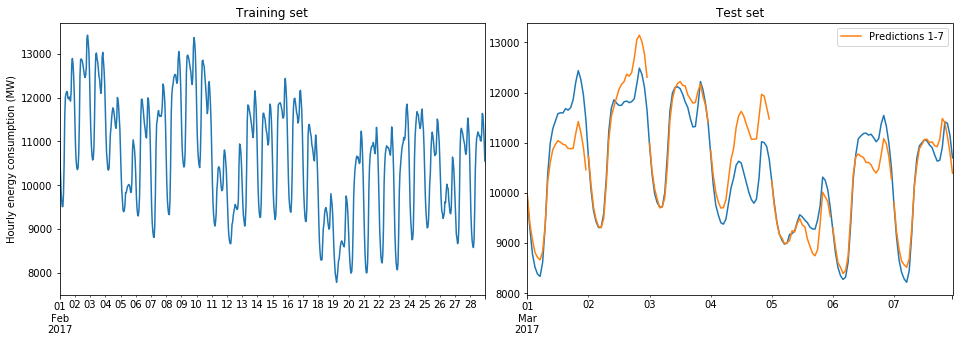

In [6]:
# Load model and predict
saved_model = sarimax.SARIMAXResults.load("Results/arima_2")
fit_model = arima_model.filter(saved_model.params)  # add the trained parameters to the model
Y_pred = predict(Y_total, fit_model, start, train_period, pred_period, pred_times, model_type='SARIMAX',
                 orders=arima_orders, seasonal_orders=seasonal_orders, X_data=X_total)

We see pretty good accuracy. With a sMAPE of 0.55 the model is almost twice as good as a simple naïve forecast. It seems to find the different patterns quite well, but has some trouble with the level of the prediction. We would probably be able to improve the model even more by incorporating the weekday season the same way as the hour per day season (with differencing, moving average and auto-regressive terms). We could also try to see if the season has a multiplicative effect instead of an additive effect. In the end we are able to adjust the model in several ways, but to get to the ‘perfect’ model this requires quite some (time consuming) analysis and optimizing. This is why making good statistical models great requires significant __modeling time__. Machine learning models are mostly used under the assumption that they are general enough to perform well without spending much time modeling. Let's see if this is the case.

In the other corner we have our machine learning model: A neural network model based on LSTM cells. LSTM cells were created to be able to deal with time better than traditional recurrent neural network cells. Due to its structure, it ‘determines’ what time lags should be memorized, what lags should be forgotten and what lags should be used for the output when they go through the cell. We set up a layer of 48 LSTM cells followed by a regular feed forward neural network layer with 24 cells, which is the number we want as output. After this we train the model and get the results shown below. 

In [7]:
# Import needed Keras parts
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks.callbacks import ModelCheckpoint, CSVLogger
from sklearn.preprocessing import MinMaxScaler

# Function that scales data, only return the scaler from the Y data
# Y_data:   pd.Series,      Pandas Series (or DataFrame) of independent data
# X_data:   pd.DataFrame,   Pandas DataFrame of dependent data
def scale_data(Y_data, X_data=None):
    scaler_Y = MinMaxScaler((0, 1))  # define scaler to normalize data (0 to 1 since we are using tanh as activation)
    scaler_Y.fit(Y_data.values.reshape((-1, 1)))  # fit scaler
    scaled_Y = scaler_Y.transform(Y_data.values.reshape((-1, 1)))  # normalize data
    scaled_Y = pd.Series(scaled_Y[:, 0], index=Y_data.index)  # return the scaled data as a Series object

    if X_data is None:
        return scaler_Y, scaled_Y
    else:  # only scale X is X data is given
        scaler_X = MinMaxScaler((0, 1))
        scaler_X.fit(X_data.values)  # fit scaler
        scaled_X = scaler_X.transform(X_data.values)  # normalize data
        scaled_X = pd.DataFrame(scaled_X, index=X_data.index)  # return the scaled data as a DataFrame object
        
        return scaler_Y, scaled_Y, scaled_X


# Function that returns the input and output data to train a neural network model
# data:             np.array,   One dimensional array of dependent data
# timestep_n:       int,        Number of time steps that is wanted for the train data
# output_n:         int,        Length of the output vector
# X_data:           np.array,   Two dimensional array of independent data
# random_samples:   bool,       If true sample_n needs to be given a value because random samples will be chosen
# sample_n:         int,        Number of samples that will be generated
# sample_steps:     int,        At how many steps in the data a sample is taken
def get_samples(data, timestep_n, output_n, X_data=None, random_samples=False, sample_n=0, sample_steps=1):
    feature_n = X_data.shape[1] + 1 if X_data is not None else 1
    data_len = data.shape[0]
    sample_max = data_len - timestep_n - output_n
    sample_n = sample_n if random_samples else int(sample_max / sample_steps)
    iter_range = range(0, int(sample_n * sample_steps), sample_steps)
    data_input = np.zeros((sample_n, timestep_n, feature_n))
    data_output = np.zeros((sample_n, output_n))

    for i in range(sample_n):  # create sample_n samples
        iter_int = np.random.randint(sample_max) if random_samples else iter_range[i]  # select int that defines sample
        data_input[i, :, 0] = data[iter_int:(iter_int + timestep_n), 0]
        if X_data is not None:
            data_input[i, :, 1:] = X_data[iter_int:(iter_int + timestep_n), :]
        data_output[i, :] = data[(iter_int + timestep_n):(iter_int + timestep_n + output_n), 0]

    return data_input, data_output

Using TensorFlow backend.


In [8]:
# Now we set up a basic LSTM to compare
output_n = forecast_horizon  # the model will give the full forecasting horizon as output
timestep_n = 1 * 7 * 24  # define length of input (number of time steps used to predict)
scaler, Y_total_norm = scale_data(Y_total)  # we scale the data

# Define the model
input_layer = Input(shape=(None, 1))  # define the input layer to take flexible time steps and 1 feature
hidden_layer = LSTM(48, return_sequences=False)(input_layer)  # add lstm layer with 48 units and only return one time unit
output_layer = Dense(output_n)(hidden_layer)  # layer with the right output
lstm_model = Model(input_layer, output_layer)  # define model input and output

In [ ]:
# Train model
train_data = Y_total_norm[train_range].values.reshape(-1, 1)  # define train data
X_train, Y_train = get_samples(train_data, timestep_n, output_n)  # get data in the right format for keras
callback_model = ModelCheckpoint("Results/lstm_1.hdf5", monitor='val_loss', save_best_only=True)  # save the best model
callback_history = CSVLogger("Results/lstm_1.csv")  # save the training history
lstm_model.compile(Adam(), loss='mean_absolute_error')  # compile model
lstm_model.fit(X_train, Y_train, batch_size=10, epochs=500, validation_split=0.15,  # train the model
               callbacks=[callback_model, callback_history]) # we validate on about half a week

The error metrics for these predictions are the following: 3.29% (sMAPE) and 0.53 (MASE)


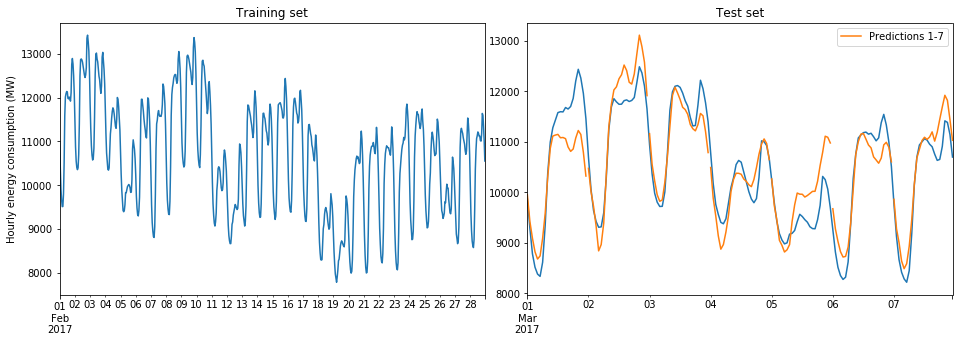

In [9]:
# Load model and predict
fit_model = load_model("Results/lstm_1.hdf5")  # load the best model
Y_pred = predict(Y_total, fit_model, start, train_period, pred_period, pred_times, model_type='KERAS',
                 Y_data_scaled=Y_total_norm, scaler=scaler)

This LSTM model appears to be as accurate as the SARIMA model. It looks like it figured out both seasonal patterns without having any input specifying them. This shows that the machine learning model has better __learnability__ than the statistical model. The statistical model learns how the different specified terms change the outcome by optimizing the model parameters, but due to its structure it will not learn anything outside of that scope. On the other hand, the machine learning model managed to determine important time lags without us giving it any direction.

## Round two: Going in with full force
Why only train on 4 weeks of data when we have such a big data set? There are no limitations on how hard a boxer is allowed to hit either. In this second round we do not limit the models and instead of training on 4 weeks of data, we use 4 years. Let’s start with the SARIMA model. Below are the obtained results.## 3. Round two: Going in with full force
Why only train on 4 weeks of data when we have such a big data set? There are no limitations on how hard a boxer is allowed to hit either. In this second round we do not limit the models and instead of training on 4 weeks of data, we use 4 years. Let’s start with the SARIMA model. Below are the obtained results.

In [10]:
# Initialize periods
start_year, start_month, start_day = 2013, 2, 27
start = dt.datetime(start_year, start_month, start_day)
train_period = dt.timedelta(weeks=209)  # 4 years of training data
train_range, pred_range = get_ranges(start, train_period, pred_period, pred_times)  # keep prediction period the same
Y_total, X_total = get_data(train_range, pred_range, comed_data, lags_endo=[7 * 24])  # get the right data

# Define model
arima_orders, seasonal_orders = (1, 1, 0), (2, 0, 1, 24)  # orders used for the arima model
arima_model = sarimax.SARIMAX(Y_total[train_range], order=arima_orders, seasonal_order=seasonal_orders,
                              exog=X_total.loc[train_range, :])  # define model

In [ ]:
# Train model
fit_model = arima_model.fit()  # train arima model
fit_model.save("Results/arima_3", remove_data=True)

In [ ]:
# Load model and predict
saved_model = sarimax.SARIMAXResults.load("Results/arima_3")
fit_model = arima_model.filter(saved_model.params)  # add the trained parameters to the model
Y_pred = predict(Y_total, fit_model, start, train_period, pred_period, pred_times, model_type='SARIMAX',
                 orders=arima_orders, seasonal_orders=seasonal_orders, X_data=X_total)

Maybe a bit surprising, but based on the sMAPE this model is significantly less accurate than the model we got when training on less data (1.29% difference). Since everything was kept the same except the increased training data, this can be the only reason why. Energy consumption clearly changes significantly throughout the year, but we are only predicting the first week of March. Therefore, it makes sense that just using data from February yields better results. Also, the similar value of the MASE (0.57 compared to 0.55) indicates that the model’s accuracy is similar compared to the naïve forecast of the training data. Therefore, we can conclude that the data has more variety throughout the year than in February. It is always important to realize what data you use for training and what you are trying to predict. More data is not always better! Let’s see what happens in the case of the LSTM model. Below are the results.

In [ ]:
# Now we do the same with LSTM (we already defined Y_total and the lstm_model before)
timestep_n = 4 * 7 * 24  # predict based on values from the past month
scaler, Y_total_norm = scale_data(Y_total)  # we scale the data before we start training

In [ ]:
# Train model
train_data = Y_total_norm[train_range].values.reshape(-1, 1)
X_train, Y_train = get_samples(train_data, timestep_n, output_n)  # get data in the right format for keras
callback_model = ModelCheckpoint("Results/lstm_2.hdf5", monitor='val_loss', save_best_only=True)  # save the best model
callback_history = CSVLogger("Results/lstm_2.csv")  # save the training history
lstm_model.compile(Adam(), loss='mean_absolute_error')  # compile model
lstm_model.fit(X_train, Y_train, batch_size=10, epochs=50, validation_split=1/(4*12),  # validate on the last month
              callbacks=[callback_model, callback_history]) # train 

In [ ]:
# Load model and predict
fit_model = load_model("Results/lstm_2.hdf5")  # load the best model
Y_pred = predict(Y_total, fit_model, start, train_period, pred_period, pred_times, model_type='KERAS',
                 Y_data_scaled=Y_total_norm, scaler=scaler)

Contrary to the results we got from the SARIMA model, the LSTM model seems to be significantly more accurate when training on more data. This means that the reasoning presented for the worse accuracy of the statistical model does not seem to hold for the machine learning model. The model seems to have been able to use the extra data to better identify the occurring pattern instead of being thrown off by the changes of energy consumption throughout the year. This is why we can state that machine learning models tend to have a higher __data utility__, i.e. additional data has a more positive effect on the accuracy of the model.

## Round three: Coach gives critical advice
Even though it is the boxer that does the fighting, input from their coach is essential. Let's see if we can further improve our models if we give them some input from outside: An exogenous variable. We obtained a dataset with the hourly weather at the Chicago Midway International Airport. Even though this is not completely representative for the weather in the whole area from which the energy consumption is taken, we assume it is a decent proxy. We will use temperature since it is expected to have the highest causational effect on energy consumption. Below is a plot of the hourly temperature on top of the hourly energy consumption.

In [ ]:
# Get weather data
weather_data = pd.read_csv("Data/Chicago_MDW_weather_2010-2018.csv", dtype='unicode')  # note that weather data is in dayss
weather_data['Datetime'] = pd.to_datetime(weather_data['DATE'])  # set index to datetime values
weather_data.index = weather_data['Datetime']
weather_hourly = weather_data.loc[weather_data['REPORT_TYPE'] == 'FM-15',  # get hourly data
                                  weather_data.columns[weather_data.columns.str.startswith('Hourly')]].copy()
weather_hourly = weather_hourly.loc[weather_hourly['HourlyDryBulbTemperature'].notna()]  # remove NaNs
weather_hourly = weather_hourly.loc[weather_hourly['HourlyDryBulbTemperature'] != "*"]  # remove *s
suspect_values_loc = weather_hourly['HourlyDryBulbTemperature'].str.endswith('s') & \
                     weather_hourly['HourlyDryBulbTemperature'].notna()  # get suspect values (assume they are usable)
weather_hourly.loc[suspect_values_loc, 'HourlyDryBulbTemperature'] = \
    weather_hourly.loc[suspect_values_loc, 'HourlyDryBulbTemperature'].str[:-1]  # remove their 's'
weather_hourly['HourlyDryBulbTemperature'] = pd.to_numeric(weather_hourly['HourlyDryBulbTemperature'])  # make numeric
weather_hourly = weather_hourly.groupby(weather_hourly.index.to_period('H')).mean()  # average over hours
weather_hourly.index = weather_hourly.index.to_timestamp()  # set back to datetime object
weather_hourly = weather_hourly.sort_index()  # sort the index
temperature_hourly = weather_hourly['HourlyDryBulbTemperature']
temp_hourly = interpolate(temperature_hourly) # interpolate missing values

# Make plot including energy data
t_ax = pd.date_range(comed_data.index[0], comed_data.index[-1], freq='H')
fig, ax1 = plt.subplots()  # create figure
ax2 = ax1.twinx()  # get second axis
ax1.set_xlabel('Year')
ax1.set_ylabel('Hourly energy consumption (MW)')
ax1.plot(t_ax, comed_data[t_ax], color='C0')
ax2.plot(t_ax, temp_hourly[t_ax], color='C3')
ax2.legend(labels=['Hourly temperature(\'F)']);

Based on this plot we can see that energy consumption goes up when the temperature is low, but also when the temperature is high. This is to be expected in Chicago, where high temperatures make cooling necessary and low temperatures require heating. We add the two lags with the highest correlation with energy consumption to our SARIMA model. This way we deviate a bit from time series analysis and turn the model partially in a regression model, but this combination hopefully allows the model to have better predictive power. We only use the data from February to train on since that gave us better results before. We make the (not completely accurate) assumption that temperature is known for the next 24 hours. Below are the results.

In [ ]:
# We go back to the initial initialization
start_year, start_month, start_day = 2017, 2, 1  # start date
start = dt.datetime(start_year, start_month, start_day)
train_period = dt.timedelta(weeks=4)  # period we select as training data
train_range, pred_range = get_ranges(start, train_period, pred_period, pred_times)  

# Get data including temperature to train on
Y_total, X_total = get_data(train_range, pred_range, comed_data, lags_endo=[7 * 24], X_data=temp_hourly,
                           lags_exo=[3, 27])  # add the two lags with the highest correlation
train_range_adjusted = (train_range + dt.timedelta(weeks=1))[:-24 * 7]  # adjust training range to remove first week

In [ ]:
# Do auto_arima to get best model orders
auto_arima(Y_total, exog=X_total, m=24)

In [ ]:
# Define model
arima_orders, seasonal_orders = (2, 0, 2), (0, 0, 2, 24)  # orders obtained from auto_arima
arima_model = sarimax.SARIMAX(Y_total[train_range_adjusted], order=arima_orders, seasonal_order=seasonal_orders,
                              exog=X_total.loc[train_range_adjusted, :])  # define model

In [ ]:
# Train model
fit_model = arima_model.fit()  # train arima model
fit_model.save("Results/arima_4", remove_data=True)

In [ ]:
# Load model and predict
saved_model = sarimax.SARIMAXResults.load("Results/arima_4")
fit_model = arima_model.filter(saved_model.params)  # add the trained parameters to the model
Y_pred = predict(Y_total, fit_model, start, train_period, pred_period, pred_times, model_type='SARIMAX',
                 orders=arima_orders, seasonal_orders=seasonal_orders, X_data=X_total, X_or=temp_hourly)

We see a clear improvement (0.36% sMAPE) in comparison with the earlier SARIMA model. But next to the improvement in accuracy, the structure of the SARIMA model gives us the ability to provide an answer to the question what the effect of temperature is on energy consumption. Predictive models are built on the premise that there is some relation between independent and dependent variables. Since statistics is a field of testing hypotheses around metrics that frequently relate to causality, statistical models are mostly easy to interpret and therefore yield great __explainability__. Let's look at the parameter coefficients below to see what we learn.

In [ ]:
# Print the model parameter coefficients
print("The SARIMA model parameter coefficients are as follows:")
print(fit_model.params)

Based on these parameters we can state a few things: The energy consumption of the next hour depends most heavily on the energy consumption of the week before (Y-168) and the energy consumption of the hour before (ar.L1), since both coefficients are above 0.90. A model error (difference between actual and predicted value) in one of the last two hours (ma.L1 and ma.L2) or 24 hours ago (ma.S.L24) will adjust the energy consumption of the predicted hour by about a third of its magnitude (all three coefficients between 0.29 and 0.38). For each degree Fahrenheit increase three hours before prediction (X-3), assuming everything else stays the same, the energy consumption will decrease by about 7 megawatt. This same increase for 27 hours before prediction (X-27) results in an increase of about 3 megawatt. The negative relationship makes sense since higher temperatures in February should lead to less heating. The positive relationship can be explained as being a counterbalance to the negative relationship. This combination of values indicates a negative relationship between energy consumption and temperature increase. 

Let’s see how the LSTM model does. We adjust the model to have a second input and train it on 4 years of energy consumption and temperature data. Below are the results.

In [ ]:
# Initialize periods
start_year, start_month, start_day = 2013, 2, 27
start = dt.datetime(start_year, start_month, start_day)
train_period = dt.timedelta(weeks=209)  # 4 years of training data
train_range, pred_range = get_ranges(start, train_period, pred_period, pred_times)  # keep prediction period the same

# Redefine the model
input_layer = Input(shape=(None, 2))  # this time the input will take 2 features
hidden_layer = LSTM(48, return_sequences=False)(input_layer)  # add lstm layer with 48 units and only return one time unit
output_layer = Dense(output_n)(hidden_layer)  # layer with the right output
lstm_model = Model(input_layer, output_layer)  # define model input and output

# Get the right data
timestep_n = 4 * 7 * 24  # define length of input (number of time steps used to predict)
Y_total, X_total = get_data(train_range, pred_range, comed_data, X_data=temp_hourly, lags_exo=[0])  # add temperature
scaler, Y_total_norm, X_total_norm = scale_data(Y_total, X_total)  # we scale the data before we start training

In [ ]:
# Train and save model
train_data = Y_total_norm[train_range].values.reshape((-1, 1))
X_train_data = X_total_norm.shift(-output_n).loc[train_range, :].values  # we assume we know the temp of the next day
X_train, Y_train = get_samples(train_data, timestep_n, output_n, X_data=X_train_data)  # get data in the right format 
callback_model = ModelCheckpoint("Results/lstm_3.hdf5", monitor='val_loss', save_best_only=True)  # save the best model
callback_history = CSVLogger("Results/lstm_3.csv")  # save the training history
lstm_model.compile(Adam(), loss='mean_absolute_error')  # compile model
lstm_model.fit(X_train, Y_train, batch_size=10, epochs=40, validation_split=1/(4*12),  # train the model
              callbacks=[callback_model, callback_history]) 

In [ ]:
# Load model and predict
fit_model = load_model("Results/lstm_3.hdf5")  # load the best model
Y_pred = predict(Y_total, fit_model, start, train_period, pred_period, pred_times, model_type='KERAS',
                 Y_data_scaled=Y_total_norm, scaler=scaler, X_data=X_total_norm.shift(-output_n),
                 X_or=temp_hourly)

We see an even bigger improvement! A sMAPE of 1.28% makes this model really accurate. However, due to this model having 10,968 parameters, we are not able to get any explanation on the effect of temperature or different time lags on the results. Also, optimizing such a big number of parameters doesn’t happen overnight. It took more than 10 hours to train this LSTM model. With the SARIMA model having less than 10 parameters, it is clear why the __training time__ is significantly lower. When a model requires frequent updates to keep accuracy high, it can be of great benefit to have a model that trains quick.

## Who is the winner?
No knockouts today, but I am sure you had as much excitement as I did watching this match! Who did you think should win? Looking at the match statistics, which are the performance indicators in our case, this is not so easy. Each indicator makes one model preferable over the other, so it depends on what you value most. Below is a graph with both models and the different indicators that make the model more preferable to the other. Hopefully this this can help as a guideline when deciding on a model type for a project. 

<img src="Results/Indicators_graph.png">

Note that data utility ended up in the middle. Didn’t we see that the machine learning model got more accurate when using more data? It did, but that makes it a drawback to. Being able to get more value from data could also mean that the machine learning model is more dependent on data.

You probably noticed that there is one performance metric missing from the graph: __Accuracy__. Even though it has been clearly present throughout this analysis, we haven’t discussed it explicitly. Accuracy is often seen as the most important performance metric, since our main goal is to have accurate predictions. In this case the machine learning model outperformed the statistical model quite significantly. However, as said before, statistical models work better when more time is spent on optimizing the model. We did not take the time to fine tune the model, while we did allow the machine learning model to train as long as it needed to get (close to) its optimum. Also, one single case doesn't prove one model is more accurate than the other in general. Below is a summary of the error metrics in the different rounds. 

<img src="Results/Error_metrics_table.png">

In literature there has been an ongoing discussion on which type of models are more accurate. Due to statisticians relying on what has been the benchmark for years and computer scientists foreseeing endless capabilities with the recent rise of deep learning, it is not as easy to find an unbiased comparison. Comparisons are made frequently, but in the end the comparison for accuracy is only fair if both models are made by specialists in the field. So, what were the results of the last M competition I mentioned? The results showed that the most accurate models were the ones that combined a statistical with a machine learning model. The winning model was even more innovative, since it was a true hybrid in which the parameters of the statistical model and the machine learning model were fitted concurrently. This only strengthens our conclusion that both types of models have their benefits and their drawbacks. And if you are looking to make the perfect model, the best way to do that is probably using both!

__References__

Energy consumption data set: https://www.kaggle.com/robikscube/hourly-energy-consumption#pjm_hourly_est.csv  
Weather data set: https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:14819/detail  
Makridakas Competitions: https://en.wikipedia.org/wiki/Makridakis_Competitions  
The M4 Competition: https://www.sciencedirect.com/science/article/pii/S0169207019301128